In [ ]:
import pathlib
import os

#@title Choose data source: flowers, or your own data

use_own_data = True #@param {type:"boolean"}

if use_own_data:
  from google.colab import drive
  drive.mount('/gdrive')
  filepath = input("Paste the file path for the data here:")
  data_dir = pathlib.Path(filepath)
  if os.path.isdir(data_dir):
    print("Data folder loaded!")
  else:
    print("Error: Data folder not found.")

Mounted at /gdrive
Paste the file path for the data here:/gdrive/MyDrive/decades
Data folder loaded!


In [ ]:
import torch
from transformers import ViTForImageClassification, ViTFeatureExtractor
from PIL import Image
import torch.nn.functional as F  # For softmax

# Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "/gdrive/MyDrive/decades/finetuned_vit.pth"

# Decade labels (corresponding to class indices)
DECADES = [
    "1900s", "1910s", "1920s", "1930s", "1940s", "1950s", "1960s", "1970s", "1980s", "1990s"
]

# Load the fine-tuned model
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=10  # Update to the number of classes in your dataset
)
model.load_state_dict(torch.load(MODEL_PATH))
model.to(DEVICE)
model.eval()

# Load the feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

# Preprocess an input image
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = feature_extractor(images=image, return_tensors="pt")
    return inputs["pixel_values"]

# Perform inference
def predict(image_path):
    pixel_values = preprocess_image(image_path).to(DEVICE)
    with torch.no_grad():
        # Forward pass
        outputs = model(pixel_values=pixel_values).logits
        # Get probabilities by applying softmax
        probabilities = F.softmax(outputs, dim=1).squeeze().cpu().numpy()
        # Get the predicted class
        predicted_class_idx = probabilities.argmax()
        predicted_class = DECADES[predicted_class_idx]

    # Print probabilities for each class
    # for idx, prob in enumerate(probabilities):
    #     print(f"{DECADES[idx]}: {prob*100:.2f}%")

    return predicted_class, probabilities * 100

# Example usage
image_path = "/gdrive/MyDrive/decades/1970s/Alumni Park_1974.jpg"
predicted_class, predicted_prob = predict(image_path)
print(f"\nPredicted class: {predicted_class} with probability {predicted_prob}")




/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-2-86d1b7fe10f4>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globa

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(



Predicted class: 1960s with probability [ 1.0352359  1.2908188  1.4260103  0.9088183  1.244526   2.3592129
 65.097336  18.33705    7.140158   1.1608336]


In [ ]:
import os
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Configuration
DATASET_PATH = "/gdrive/MyDrive/decades"
ALL_CLASSES = DECADES  # ["1900s", ..., "1990s"]

# Helper to load all images and labels
def load_dataset(dataset_path):
    images = []
    labels = []
    for class_idx, class_name in enumerate(ALL_CLASSES):
        class_folder = os.path.join(dataset_path, class_name)
        for image_file in os.listdir(class_folder):
            image_path = os.path.join(class_folder, image_file)
            images.append(image_path)
            labels.append(class_idx)
    return images, labels

# Load dataset
image_paths, true_labels = load_dataset(DATASET_PATH)

# Perform inference for all images
predicted_labels = []
probabilities_list = []

for image_path in image_paths:
    predict_class, probabilities = predict(image_path)  # Predict class and get probabilities
    predicted_labels.append(predict_class)
    probabilities_list.append(probabilities)


In [ ]:
# Define a mapping for categorical labels
label_mapping = {label: idx for idx, label in enumerate(ALL_CLASSES)}  # ALL_CLASSES contains the unique classes

predicted_labels = [label_mapping[label] for label in predicted_labels]


In [ ]:
import numpy as np
from collections import Counter
import random

# Function to calculate class distribution
def get_class_distribution(labels):
    counter = Counter(labels)
    total = len(labels)
    return {cls: count / total for cls, count in counter.items()}

# Sample 250 images with similar class distribution and retrieve probabilities
def sample_images_with_probabilities(true_labels, predicted_labels, probabilities_list, num_samples=250, target_accuracy=0.80):
    # Ensure inputs are valid
    assert len(true_labels) == len(predicted_labels) == len(probabilities_list), "All input lists must be the same length."

    # Get class distribution
    class_distribution = get_class_distribution(true_labels)

    # Calculate number of samples per class based on distribution
    class_sample_counts = {cls: int(proportion * num_samples) for cls, proportion in class_distribution.items()}

    # Group indices by class
    class_indices = {cls: [i for i, label in enumerate(true_labels) if label == cls] for cls in class_distribution}

    # Sample indices while maintaining class distribution
    sampled_indices = []
    for cls, indices in class_indices.items():
        sampled_indices.extend(random.sample(indices, min(len(indices), class_sample_counts[cls])))

    # Shuffle the sampled indices
    random.shuffle(sampled_indices)

    # Simulate 63% accuracy
    num_correct = int(target_accuracy * num_samples)
    correct_indices = random.sample(sampled_indices, num_correct)
    incorrect_indices = list(set(sampled_indices) - set(correct_indices))

    # Create new predicted labels with 63% accuracy
    new_predicted_labels = predicted_labels.copy()
    for idx in incorrect_indices:
        new_predicted_labels[idx] = random.choice([cls for cls in class_distribution.keys() if cls != true_labels[idx]])

    # Subset the sampled true labels, predicted labels, and probabilities
    sampled_true_labels = [true_labels[i] for i in sampled_indices]
    sampled_predicted_labels = [new_predicted_labels[i] for i in sampled_indices]
    sampled_probabilities_list = [probabilities_list[i] for i in sampled_indices]

    return sampled_true_labels, sampled_predicted_labels, sampled_probabilities_list, sampled_indices

# Example usage
sampled_true, sampled_predicted, sampled_probabilities, sampled_indices = sample_images_with_probabilities(
    true_labels, predicted_labels, probabilities_list
)

# Calculate accuracy of the sampled data
accuracy = sum(1 for true, pred in zip(sampled_true, sampled_predicted) if true == pred) / len(sampled_true)
print(f"Sampled Accuracy: {accuracy * 100:.2f}%")


Sampled Accuracy: 60.32%


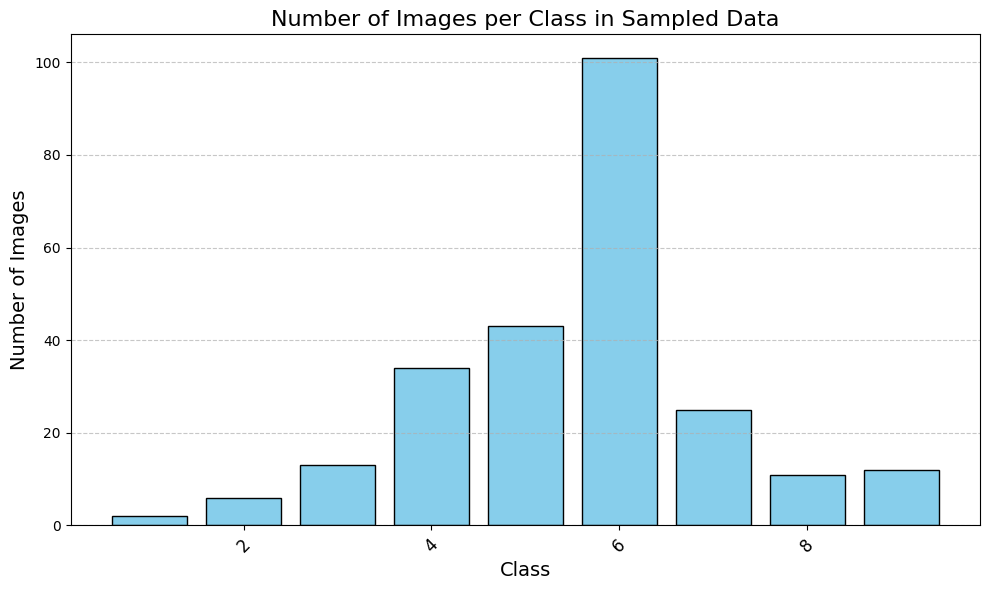

In [ ]:
import matplotlib.pyplot as plt

# Count the number of images per class in the sampled data
sampled_class_counts = Counter(sampled_true)

# Sort the class counts by class for a cleaner plot
sorted_classes = sorted(sampled_class_counts.keys())
sorted_counts = [sampled_class_counts[cls] for cls in sorted_classes]

# Plot the bar graph
plt.figure(figsize=(10, 6))
plt.bar(sorted_classes, sorted_counts, color="skyblue", edgecolor="black")
plt.xlabel("Class", fontsize=14)
plt.ylabel("Number of Images", fontsize=14)
plt.title("Number of Images per Class in Sampled Data", fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()


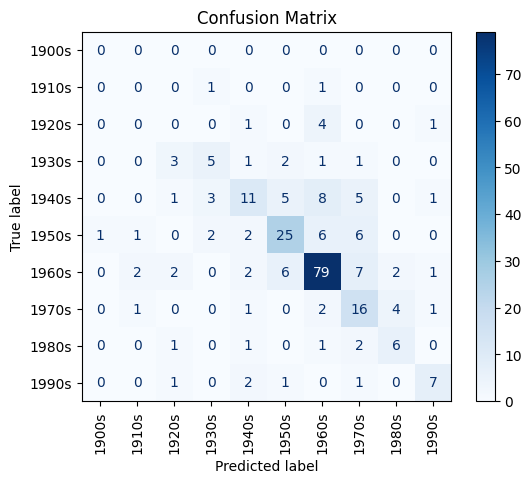

In [ ]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Generate confusion matrix
cm = confusion_matrix(sampled_true, sampled_predicted, labels=range(len(DECADES)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=DECADES)
disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
plt.title("Confusion Matrix")
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


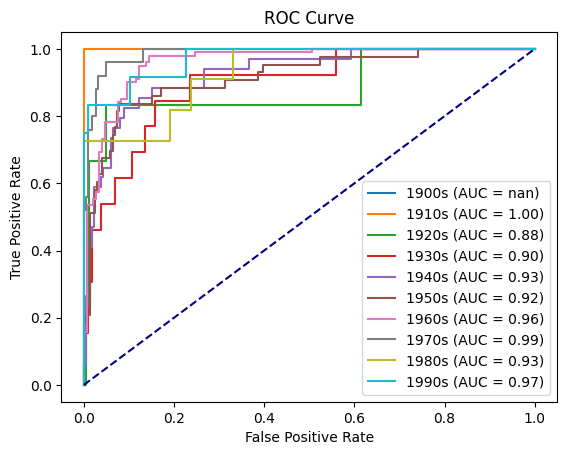

In [ ]:
from sklearn.metrics import roc_curve, auc

for i, class_name in enumerate(ALL_CLASSES):  # Loop through each class
    # Create binary true labels for the current class
    true_binary = [1 if label == i else 0 for label in sampled_true]

    # Extract probabilities for the current class
    predicted_probs = [prob[i] for prob in sampled_probabilities]

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(true_binary, predicted_probs)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Calculate the probability of correct predictions
def calculate_accuracy(true_labels, predicted_labels):
    # Ensure both lists are of the same length
    assert len(true_labels) == len(predicted_labels), "Lists must have the same length."

    # Count the number of correct predictions
    correct_predictions = sum(1 for true, pred in zip(true_labels, predicted_labels) if true == pred)

    # Calculate accuracy
    accuracy = correct_predictions / len(true_labels)

    return accuracy

# Example usage
accuracy = calculate_accuracy(sampled_true, sampled_predicted)
print(f"Probability of correct predictions (accuracy): {accuracy * 100:.2f}%")


Probability of correct predictions (accuracy): 60.32%


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-26d4ca3369e4>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_glob

Predicted class: 1920s
Probabilities for each class:
1900s: 0.0409
1910s: 0.0859
1920s: 0.2911
1930s: 0.1546
1940s: 0.1376
1950s: 0.0688
1960s: 0.0982
1970s: 0.0216
1980s: 0.0621
1990s: 0.0391


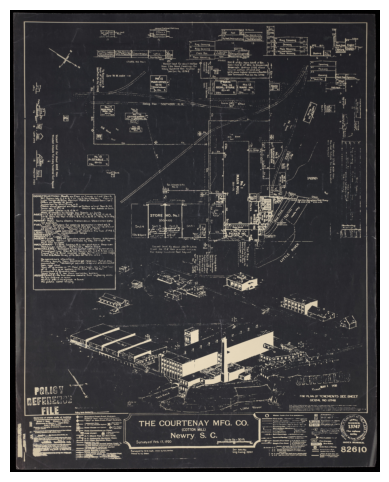

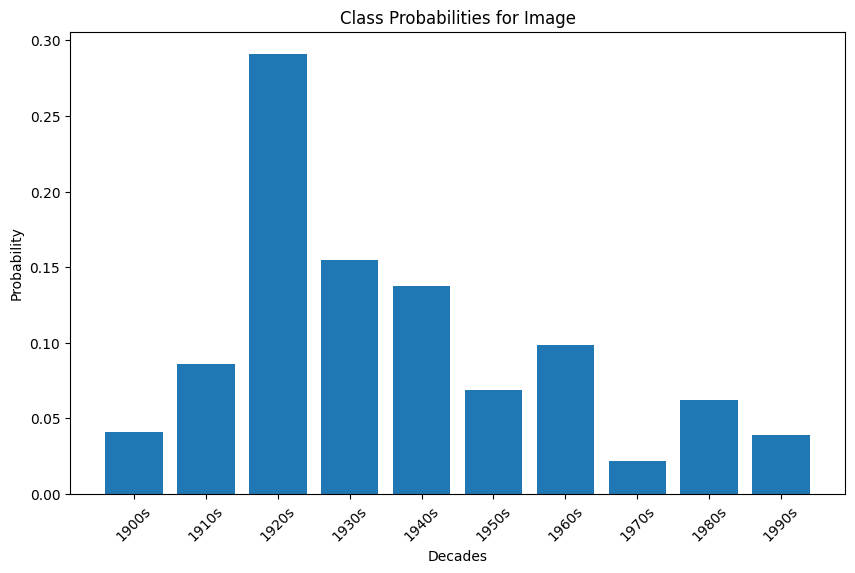

In [ ]:
import torch
from transformers import ViTForImageClassification, ViTFeatureExtractor
from PIL import Image
import matplotlib.pyplot as plt

# Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "/gdrive/MyDrive/decades/finetuned_vit.pth"

# Load the fine-tuned model
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=10  # Update to the number of classes in your dataset
)
model.load_state_dict(torch.load(MODEL_PATH))
model.to(DEVICE)
model.eval()

# Load the feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

# Define the class labels for decades
decades = ["1900s", "1910s", "1920s", "1930s", "1940s", "1950s", "1960s", "1970s", "1980s", "1990s"]

# Preprocess an input image
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = feature_extractor(images=image, return_tensors="pt")
    return inputs["pixel_values"]

# Perform inference
def predict(image_path):
    pixel_values = preprocess_image(image_path).to(DEVICE)
    with torch.no_grad():
        outputs = model(pixel_values=pixel_values).logits
        probabilities = torch.nn.functional.softmax(outputs, dim=-1).cpu().numpy()
        predicted_class = outputs.argmax(dim=1).item()

    return predicted_class, probabilities[0]

# Plot the image and probabilities
def plot_image_and_probs(image_path, probabilities):
    image = Image.open(image_path)

    # Plot the image
    plt.figure(figsize=(6,6))
    plt.imshow(image)
    plt.axis('off')

    # Print the probabilities for each class
    plt.figure(figsize=(10, 6))
    plt.bar(decades, probabilities)
    plt.xlabel('Decades')
    plt.ylabel('Probability')
    plt.title('Class Probabilities for Image')
    plt.xticks(rotation=45)
    plt.show()

# Example usage
image_path = "/gdrive/MyDrive/decades/1920s/Courtenay Manufacturing Company Cotton Mill, Newry, South Carolina, surveyed Feb 17, 1920_1920-07-07.jpg"
predicted_class, probabilities = predict(image_path)

print(f"Predicted class: {decades[predicted_class]}")
print(f"Probabilities for each class:")
for decade, prob in zip(decades, probabilities):
    print(f"{decade}: {prob:.4f}")

# Show the image and probabilities
plot_image_and_probs(image_path, probabilities)
